# Introduction
This notebook will guide you through creating a classifier from scratch that can distinguish between different types of ships.

# Prerequisites

In [1]:
# Installing livelossplot for live metrics viz
# split-folders to create test and validation datasets
!pip install livelossplot
!pip install split-folders

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tensorflow as tf
from livelossplot import PlotLossesKeras
import splitfolders
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator 
import keras
from keras import layers

# Data
### Extracting the archive containing the ships data

In [4]:
# Extract the ships archive
!tar xzf /kaggle/input/shipsmano2021/ships.tgz

### Displaying number of files

In [5]:
!find ./ships_scaled -type f | wc -l

47562


### Split training data into three folders : `train`, `val`, `test`
70 % of the data is used for training
20 % for validation
10 % for testing
This split is only done if the `split` folder does not exist already

In [6]:
if not os.path.exists("./split"):
    splitfolders.ratio("./ships_scaled/train/", "./split", seed=1, ratio=(.7, .2, .1))

### Create generators for the train, validation and test data
The images are resized to 128, 128. We use a batch size of 32.

In [7]:
data_dir = "/kaggle/working/split/"
batch_size = 32
img_height = 128
img_width = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir + "train",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir + "val",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir + "test",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 33288 files belonging to 13 classes.
Found 9507 files belonging to 13 classes.
Found 4767 files belonging to 13 classes.


### Here are the differents classes composing our dataset

In [8]:
class_names = train_ds.class_names
print(class_names)

['coastguard', 'containership', 'corvette', 'cruiser', 'cv', 'destroyer', 'ferry', 'methanier', 'sailing', 'smallfish', 'submarine', 'tug', 'vsmallfish']


### Some images from the first batch

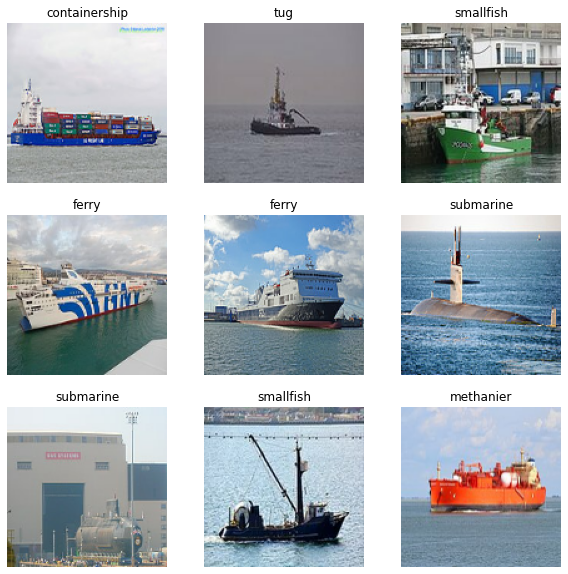

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [10]:
# This code is useful for the class weights later on. It stores the classes of the different files.
lbl = []
for dirname, _, filenames in os.walk("/kaggle/working/ships_scaled/train/"):
    for filename in filenames:
        lbl.append(dirname.split("/")[-1])

# Model

In [11]:
# Setting the prefetch to auto
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

### Here we compute the class weights to be used in the training step
The future deprecation warning are ignored

In [12]:
from sklearn.utils import class_weight
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    class_weights = class_weight.compute_class_weight('balanced', np.unique(lbl), lbl) 
    class_weights = {i : class_weights[i] for i in range(len(np.unique(lbl)))}

### We build the network

In [13]:
from keras import Sequential
from keras.layers import *

model = Sequential()
model.add(InputLayer(input_shape=(128, 128, 3)))

model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(512, (1, 1), activation='relu', strides=(1, 1), padding='same'))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())

# ANN block
model.add(Dense(units=2048, activation='relu'))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.25))
# output layer
model.add(Dense(units=13, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0

In [14]:
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  27


### The model is then compiled

In [15]:
model.compile(optimizer='adam', loss="categorical_crossentropy",
              metrics=['accuracy'])

### And fitted to the Data
We plot the loss, accuracy of the training.

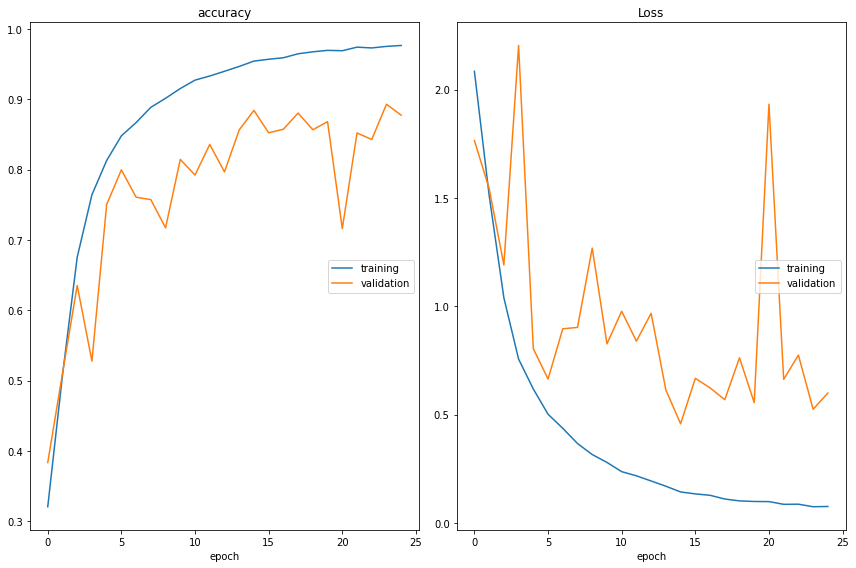

accuracy
	training         	 (min:    0.321, max:    0.977, cur:    0.977)
	validation       	 (min:    0.384, max:    0.893, cur:    0.877)
Loss
	training         	 (min:    0.075, max:    2.084, cur:    0.076)
	validation       	 (min:    0.458, max:    2.204, cur:    0.599)


In [16]:
model.fit(train_ds, validation_data=val_ds, epochs=25, class_weight=class_weights, callbacks=[PlotLossesKeras()], verbose=1)

# Evaluation

### We first evaluate the model on the test dataset

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib

This code is for printing a fancy confusion matrix.

In [18]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    if normalize:
        plt.colorbar(matplotlib.cm.ScalarMappable(norm=None, cmap=cmap))
    else:
        plt.colorbar()
        
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

149/149 [==============================] - 6s 38ms/step - loss: 0.6106 - accuracy: 0.8733


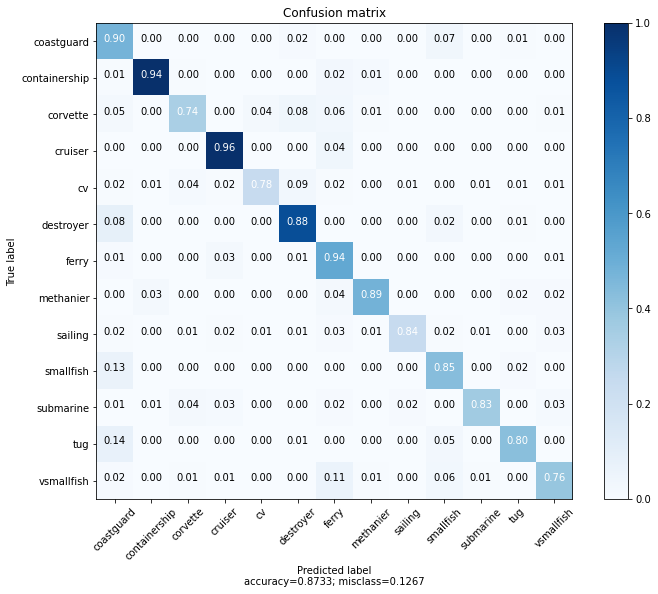

In [22]:
model.evaluate(test_ds) # Evaluation on the test dataset
pred_y = model.predict(test_ds).argmax(axis=1) # Prediction on the test dataset, should be the same as evaluation
y = np.concatenate([y for x, y in test_ds], axis=0).argmax(axis=1) # We retrieve the labels from the test dataset
plot_confusion_matrix(confusion_matrix(y, pred_y), class_names, normalize=True) # We print the confusion matrix

In [23]:
print(classification_report(y, pred_y, target_names=class_names))

               precision    recall  f1-score   support

   coastguard       0.62      0.90      0.74       322
containership       0.97      0.94      0.96       646
     corvette       0.88      0.74      0.80       279
      cruiser       0.96      0.96      0.96       639
           cv       0.91      0.78      0.84       193
    destroyer       0.91      0.88      0.90       612
        ferry       0.73      0.94      0.82       343
    methanier       0.95      0.89      0.92       330
      sailing       0.93      0.84      0.88       177
    smallfish       0.78      0.85      0.81       311
    submarine       0.96      0.83      0.89       271
          tug       0.92      0.80      0.86       326
   vsmallfish       0.89      0.76      0.82       318

     accuracy                           0.87      4767
    macro avg       0.88      0.85      0.86      4767
 weighted avg       0.89      0.87      0.88      4767



### Test on 20 images we found
#### Cloning the repo containing the images...

In [24]:
!git clone https://github.com/elrandar/shipsdataset.git
!rm shipsdataset/README.md
!rm -rf shipsdataset/.git/

Cloning into 'shipsdataset'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 77 (delta 3), reused 75 (delta 1), pack-reused 0
Unpacking objects: 100% (77/77), done.


#### Creating Dataset

In [25]:
test_20_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "shipsdataset/",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 20 files belonging to 13 classes.


#### Showing the images

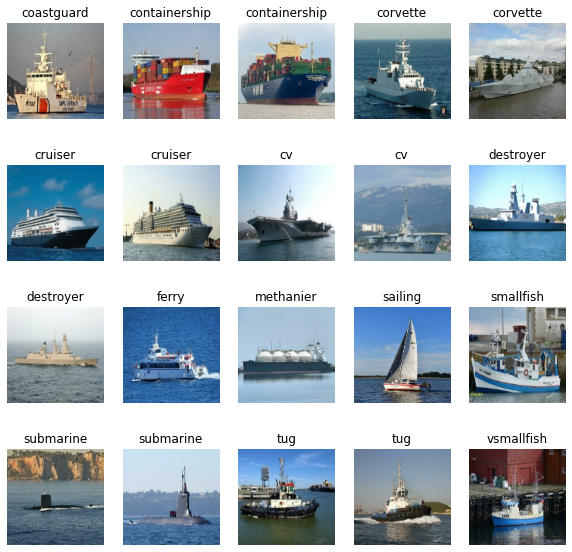

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in test_20_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

1/1 [==============================] - 0s 369ms/step - loss: 0.6018 - accuracy: 0.9000


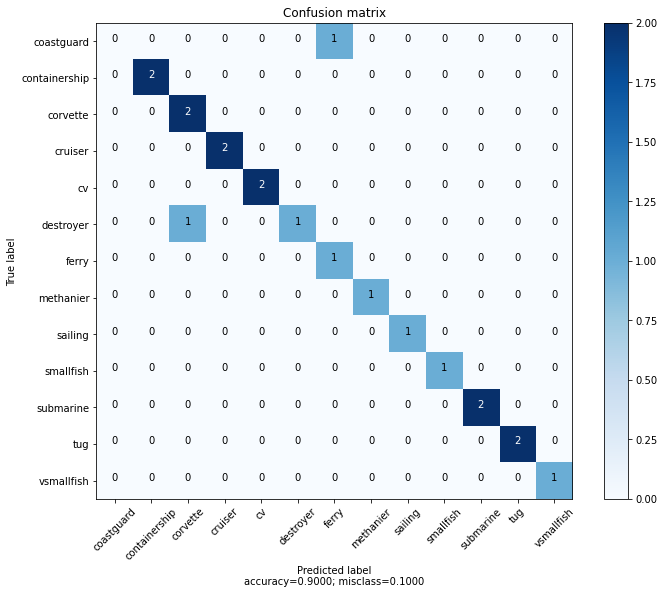

In [27]:
model.evaluate(test_20_ds)
pred_y = model.predict(test_20_ds).argmax(axis=1)
y = np.concatenate([y for x, y in test_20_ds], axis=0).argmax(axis=1)
plot_confusion_matrix(confusion_matrix(y, pred_y), class_names, normalize=False)

# Submission
For the submission, the dataset is rescaled then evaluated

In [28]:
X_test = np.load('/kaggle/working/test.npy', allow_pickle=True)

In [29]:
from skimage.transform import resize

X_test_resized = np.zeros((len(X_test), 128, 128, 3))
for n, i in enumerate(X_test):
    X_test_resized[n] = resize(X_test[n], (128, 128), preserve_range=True)

In [30]:
X_test_resized.shape

(1270, 128, 128, 3)

In [31]:
res = model.predict(X_test_resized).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="Id")

In [32]:
!head reco_nav.csv

Id,Category
0,0
1,11
2,11
3,11
4,1
5,8
6,11
7,5
8,0


In [33]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv